# Math Problem Solving: Single vs Multi-Agent Comparison

This notebook compares single-agent and multi-agent approaches for solving GSM8K-style math problems with verifiable outcomes.

**Approaches:**
- **Single Agent**: One agent with all math tools
- **Multi-Agent**: Specialist agents (arithmetic, growth, equations) coordinated by an orchestrator

## Setup & Imports

In [3]:
import asyncio
import time
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pydantic import BaseModel, Field

from cogent import Agent, Observer, tool

# Configure matplotlib for SVG output and better styling
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Tool Definitions

Math operation tools with exact computation:

In [4]:
@tool
def calculator(expression: str) -> float:
    """Evaluate a mathematical expression safely.
    
    Args:
        expression: Math expression (e.g., "50 * 3", "200 + 150", "1000 - 105")
    
    Returns:
        The numerical result
    """
    allowed_chars = set("0123456789+-*/()., ")
    if not all(c in allowed_chars for c in expression):
        raise ValueError(f"Expression contains invalid characters: {expression}")
    
    try:
        result = eval(expression)
        return float(result)
    except Exception as e:
        raise ValueError(f"Failed to evaluate '{expression}': {e}")


@tool
def calculate_percentage(value: float, percentage: float) -> float:
    """Calculate a percentage of a value.
    
    Args:
        value: The base value
        percentage: The percentage (e.g., 40 for 40%)
    
    Returns:
        The calculated amount
    """
    return (value * percentage) / 100


@tool
def calculate_growth_rate(initial: float, final: float) -> float:
    """Calculate the growth rate between two values.
    
    Args:
        initial: Starting value
        final: Ending value
    
    Returns:
        Growth rate as a percentage
    """
    if initial == 0:
        raise ValueError("Initial value cannot be zero")
    return ((final - initial) / initial) * 100


@tool
def calculate_compound_growth(initial: float, rates: list[float]) -> float:
    """Calculate final value after applying multiple growth rates sequentially.
    
    Args:
        initial: Starting value
        rates: List of growth rates as percentages (e.g., [15, 23, -8, 31])
    
    Returns:
        Final value after all growth applied
    """
    value = initial
    for rate in rates:
        value = value * (1 + rate / 100)
    return value


@tool
def calculate_average(values: list[float]) -> float:
    """Calculate the arithmetic mean of a list of values.
    
    Args:
        values: List of numbers
    
    Returns:
        The average value
    """
    if not values:
        raise ValueError("Cannot calculate average of empty list")
    return sum(values) / len(values)


@tool
def solve_linear_equation(a: float, b: float) -> float:
    """Solve linear equation: ax + b = 0
    
    Args:
        a: Coefficient of x
        b: Constant term
    
    Returns:
        Solution for x
    """
    if a == 0:
        raise ValueError("Coefficient 'a' cannot be zero in linear equation")
    return -b / a


print("✓ Tools defined")

✓ Tools defined


## Problem Definitions

GSM8K-style math problems with exact answers:

In [5]:
@dataclass
class MathProblem:
    """A math problem with a verifiable answer."""
    question: str
    ground_truth: float
    description: str


PROBLEMS = [
    MathProblem(
        question="""A company's revenue was $2.4M at the start of the year.
It grew 15% in Q1, 23% in Q2, fell 8% in Q3, then grew 31% in Q4.
What was the final revenue? Also calculate the average quarterly growth rate.""",
        ground_truth=4091412.96,
        description="Compound growth"
    ),
    
    MathProblem(
        question="""A store had 150 apples. On Monday, they sold 40% of them.
On Tuesday, they received a shipment that increased their stock by 60 apples.
On Wednesday, they sold 25% of their current stock.
How many apples remain?""",
        ground_truth=112.5,
        description="Multi-step percentages"
    ),
    
    MathProblem(
        question="""A carnival booth made $50 per day selling popcorn.
It made three times as much selling cotton candy each day.
Over 5 days, the booth earned revenue but had to pay $30 rent and $75 for ingredients.
What was the profit after expenses?""",
        ground_truth=895.0,
        description="Revenue & expenses"
    ),
]

print(f"✓ {len(PROBLEMS)} problems defined:")
for i, p in enumerate(PROBLEMS, 1):
    print(f"  {i}. {p.description}: Answer = {p.ground_truth:,.2f}")

✓ 3 problems defined:
  1. Compound growth: Answer = 4,091,412.96
  2. Multi-step percentages: Answer = 112.50
  3. Revenue & expenses: Answer = 895.00


## Structured Output Schema

In [6]:
class MathSolution(BaseModel):
    """Structured output for math problem solutions."""
    reasoning: str = Field(description="Step-by-step explanation of how you solved the problem")
    final_answer: float = Field(description="The final numerical answer to the problem")


print("✓ Output schema defined")

✓ Output schema defined


## Agent Setup

### Single Agent (all tools)

In [12]:
single_agent = Agent(
    name="MathSolver",
    model="gemini:gemini-2.5-pro",
    instructions="""You are an expert mathematics problem solver.
    
Solve problems step-by-step using the available tools.
Show your reasoning clearly, then provide the final numerical answer.""",
    tools=[
        calculator,
        calculate_percentage,
        calculate_growth_rate,
        calculate_compound_growth,
        calculate_average,
        solve_linear_equation,
    ],
)

print("✓ Single agent created")

✓ Single agent created


### Multi-Agent (specialists + orchestrator)

In [13]:
# Arithmetic specialist
arithmetic_expert = Agent(
    name="ArithmeticExpert",
    model="gemini:gemini-2.5-flash",
    instructions="""You are an arithmetic specialist.
    
Use the calculator and percentage tools to perform calculations accurately.
Show each step of your work clearly.""",
    tools=[calculator, calculate_percentage],
)

# Growth/statistics specialist
growth_expert = Agent(
    name="GrowthExpert",
    model="gemini:gemini-2.5-flash",
    instructions="""You are a growth and statistics specialist.
    
Use growth rate and compound growth tools to analyze changes over time.
Calculate averages when needed.""",
    tools=[calculate_growth_rate, calculate_compound_growth, calculate_average],
)

# Equation solver specialist
equation_expert = Agent(
    name="EquationExpert",
    model="gemini:gemini-2.5-flash",
    instructions="""You are an equation solving specialist.
    
Solve linear equations using the provided tool.
Explain the solution process.""",
    tools=[solve_linear_equation],
)

# Orchestrator that delegates to specialists
multi_agent_orchestrator = Agent(
    name="MathOrchestrator",
    model="gemini:gemini-2.5-pro",
    instructions="""You are a math problem orchestrator.
    
Break down complex problems and delegate to specialists:
- ArithmeticExpert: Basic calculations, percentages
- GrowthExpert: Growth rates, compound growth, averages
- EquationExpert: Solving equations

Synthesize their results into a final answer with clear reasoning.""",
    subagents=[arithmetic_expert, growth_expert, equation_expert],
)

print("✓ Multi-agent system created (3 specialists + orchestrator)")

✓ Multi-agent system created (3 specialists + orchestrator)


## Run Evaluation

Solve all problems with both approaches:

## Evaluation Functions

In [14]:
@dataclass
class EvaluationResult:
    """Results from solving a problem."""
    problem_description: str
    ground_truth: float
    agent_answer: float | None
    reasoning: str
    duration: float
    tokens: int
    tool_calls: int
    correct: bool


async def evaluate_approach(agent: Agent, problem: MathProblem) -> EvaluationResult:
    """Evaluate one problem with one agent."""
    start = time.time()
    response = await agent.run(problem.question, output=MathSolution)
    duration = time.time() - start
    
    # Get structured output - it's wrapped in StructuredResult
    from cogent.agent.output import StructuredResult
    if isinstance(response.content, StructuredResult):
        solution = response.content.data
    else:
        solution = response.content
    
    answer = solution.final_answer if isinstance(solution, MathSolution) else None
    reasoning = solution.reasoning if isinstance(solution, MathSolution) else "No solution provided"
    
    # Check correctness
    correct = answer is not None and answer == problem.ground_truth
    
    # Count tool calls (including subagent tool calls)
    tool_calls = len(response.tool_calls)
    if response.subagent_responses:
        for sub_resp in response.subagent_responses:
            tool_calls += len(sub_resp.tool_calls)
    
    return EvaluationResult(
        problem_description=problem.description,
        ground_truth=problem.ground_truth,
        agent_answer=answer,
        reasoning=reasoning,
        duration=duration,
        tokens=response.metadata.tokens.total_tokens,
        tool_calls=tool_calls,
        correct=correct,
    )


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [16]:
# Run all evaluations concurrently (3 problems × 2 agents = 6 concurrent tasks)
# Using TaskGroup for structured concurrency with better error handling
async with asyncio.TaskGroup() as tg:
    tasks = []
    for problem in PROBLEMS:
        tasks.append(tg.create_task(evaluate_approach(single_agent, problem)))
        tasks.append(tg.create_task(evaluate_approach(multi_agent_orchestrator, problem)))

# Extract results
results = [task.result() for task in tasks]
single_results = [results[i] for i in range(0, len(results), 2)]
multi_results = [results[i] for i in range(1, len(results), 2)]

# Display results with detailed metrics
for i, (problem, single, multi) in enumerate(zip(PROBLEMS, single_results, multi_results), 1):
    print(f"\n{'=' * 80}")
    print(f"PROBLEM {i}: {problem.description}")
    print(f"{'=' * 80}")
    print(f"Ground Truth: {problem.ground_truth:,.2f}\n")
    
    # Single agent results
    status_single = "✓ CORRECT" if single.correct else "✗ WRONG"
    print(f"Single Agent: {status_single}")
    print(f"  Answer:      {single.agent_answer:,.2f}")
    print(f"  Time:        {single.duration:.2f}s")
    print(f"  Tokens:      {single.tokens:,} total")
    print(f"  Tool Calls:  {single.tool_calls}")
    
    # Multi-agent results
    status_multi = "✓ CORRECT" if multi.correct else "✗ WRONG"
    print(f"\nMulti-Agent:  {status_multi}")
    print(f"  Answer:      {multi.agent_answer:,.2f}")
    print(f"  Time:        {multi.duration:.2f}s")
    print(f"  Tokens:      {multi.tokens:,} total")
    print(f"  Tool Calls:  {multi.tool_calls}")

print("\n" + "=" * 80)
print("✓ Evaluation complete!")
print("=" * 80)


PROBLEM 1: Compound growth
Ground Truth: 4,091,412.96

Single Agent: ✓ CORRECT
  Answer:      4,091,412.96
  Time:        15.90s
  Tokens:      2,037 total
  Tool Calls:  10

Multi-Agent:  ✓ CORRECT
  Answer:      4,091,412.96
  Time:        35.54s
  Tokens:      12,899 total
  Tool Calls:  32

PROBLEM 2: Multi-step percentages
Ground Truth: 112.50

Single Agent: ✓ CORRECT
  Answer:      112.50
  Time:        29.58s
  Tokens:      5,584 total
  Tool Calls:  12

Multi-Agent:  ✓ CORRECT
  Answer:      112.50
  Time:        34.71s
  Tokens:      14,685 total
  Tool Calls:  32

PROBLEM 3: Revenue & expenses
Ground Truth: 895.00

Single Agent: ✓ CORRECT
  Answer:      895.00
  Time:        30.44s
  Tokens:      5,442 total
  Tool Calls:  12

Multi-Agent:  ✓ CORRECT
  Answer:      895.00
  Time:        35.70s
  Tokens:      12,768 total
  Tool Calls:  32

✓ Evaluation complete!


## Results Analysis

### Summary Statistics

In [17]:
# Create comparison DataFrame
comparison_data = []

for i, (single, multi) in enumerate(zip(single_results, multi_results), 1):
    comparison_data.append({
        'Problem': f"P{i}: {single.problem_description}",
        'Ground Truth': single.ground_truth,
        'Single Answer': single.agent_answer,
        'Single Correct': '✓' if single.correct else '✗',
        'Single Time (s)': round(single.duration, 1),
        'Single Tokens': single.tokens,
        'Single Tools': single.tool_calls,
        'Multi Answer': multi.agent_answer,
        'Multi Correct': '✓' if multi.correct else '✗',
        'Multi Time (s)': round(multi.duration, 1),
        'Multi Tokens': multi.tokens,
        'Multi Tools': multi.tool_calls,
    })

df = pd.DataFrame(comparison_data)
display(df)

# Calculate totals
single_correct = sum(1 for r in single_results if r.correct)
multi_correct = sum(1 for r in multi_results if r.correct)
single_tokens = sum(r.tokens for r in single_results)
multi_tokens = sum(r.tokens for r in multi_results)
single_time = sum(r.duration for r in single_results)
multi_time = sum(r.duration for r in multi_results)
single_tools = sum(r.tool_calls for r in single_results)
multi_tools = sum(r.tool_calls for r in multi_results)

print("\n" + "=" * 70)
print("TOTALS")
print("=" * 70)
print(f"Accuracy:     Single {single_correct}/{len(PROBLEMS)} | Multi {multi_correct}/{len(PROBLEMS)}")
print(f"Total Tokens: Single {single_tokens:,} | Multi {multi_tokens:,} ({((multi_tokens/single_tokens - 1) * 100) if single_tokens > 0 else 0:+.1f}%)")
print(f"Total Tools:  Single {single_tools} | Multi {multi_tools} ({multi_tools - single_tools:+d})")
print(f"Total Time:   Single {single_time:.1f}s | Multi {multi_time:.1f}s ({((multi_time/single_time - 1) * 100) if single_time > 0 else 0:+.1f}%)")

,Problem,Ground Truth,Single Answer,Single Correct,Single Time (s),Single Tokens,Single Tools,Multi Answer,Multi Correct,Multi Time (s),Multi Tokens,Multi Tools
0,P1: Compound growth,4091412.96,4091412.96,✓,15.9,2037,10,4091412.96,✓,35.5,12899,32
1,P2: Multi-step percentages,112.50,112.50,✓,29.6,5584,12,112.50,✓,34.7,14685,32
2,P3: Revenue & expenses,895.00,895.00,✓,30.4,5442,12,895.00,✓,35.7,12768,32



TOTALS
Accuracy:     Single 3/3 | Multi 3/3
Total Tokens: Single 13,063 | Multi 40,352 (+208.9%)
Total Tools:  Single 34 | Multi 96 (+62)
Total Time:   Single 75.9s | Multi 105.9s (+39.5%)


## Visualizations

### 1. Accuracy Comparison

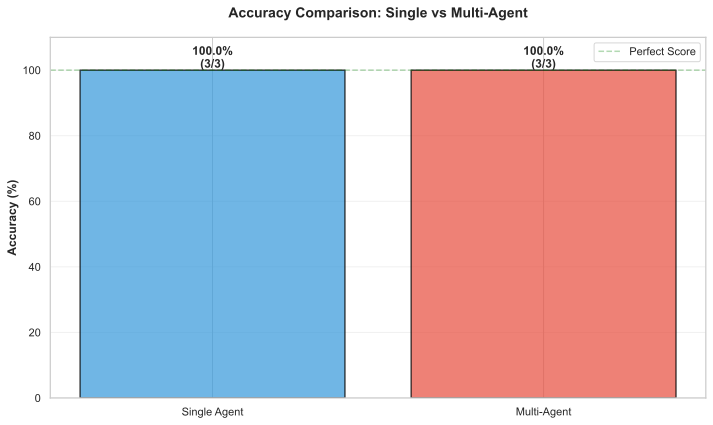

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

approaches = ['Single Agent', 'Multi-Agent']
accuracies = [single_correct / len(PROBLEMS) * 100, multi_correct / len(PROBLEMS) * 100]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(approaches, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%\n({int(acc/100*len(PROBLEMS))}/{len(PROBLEMS)})',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Comparison: Single vs Multi-Agent', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 110)
ax.axhline(y=100, color='green', linestyle='--', alpha=0.3, label='Perfect Score')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 2. Resource Usage Comparison

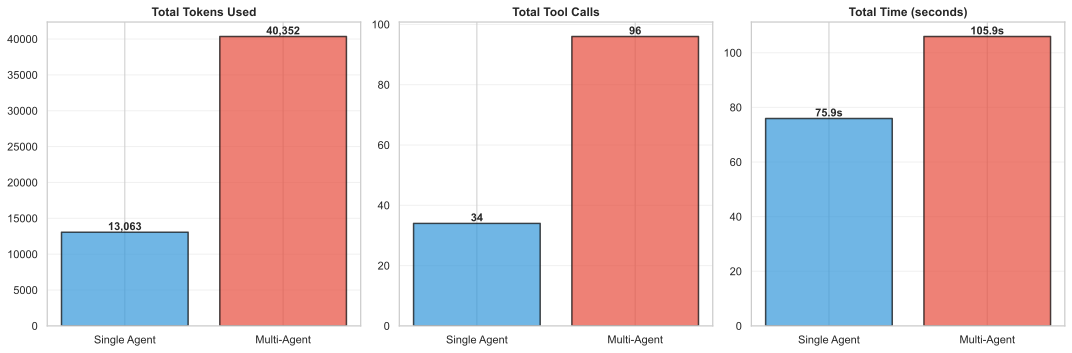

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = [
    ('Tokens', [single_tokens, multi_tokens], 'Total Tokens Used'),
    ('Tool Calls', [single_tools, multi_tools], 'Total Tool Calls'),
    ('Time (s)', [single_time, multi_time], 'Total Time (seconds)'),
]

for ax, (metric, values, title) in zip(axes, metrics):
    bars = ax.bar(approaches, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        if metric == 'Tokens':
            label = f'{int(val):,}'
        elif metric == 'Time (s)':
            label = f'{val:.1f}s'
        else:
            label = f'{int(val)}'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 3. Per-Problem Breakdown

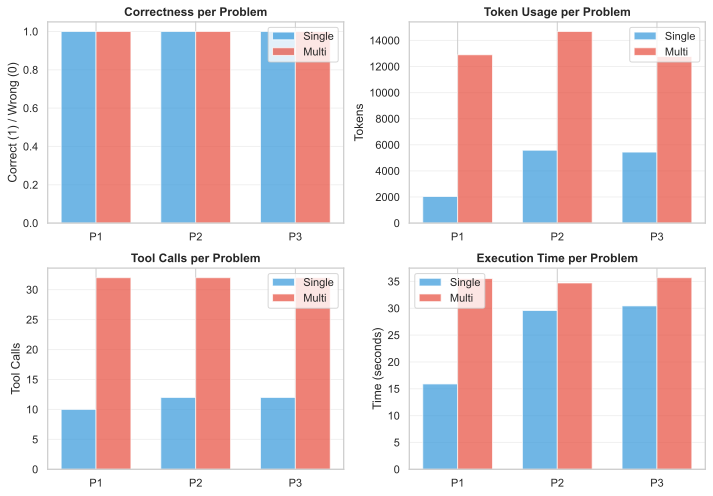

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

problem_labels = [f"P{i}" for i in range(1, len(PROBLEMS) + 1)]
x = range(len(PROBLEMS))
width = 0.35

# 1. Correctness per problem
ax = axes[0]
single_correct_vals = [1 if r.correct else 0 for r in single_results]
multi_correct_vals = [1 if r.correct else 0 for r in multi_results]

ax.bar([i - width/2 for i in x], single_correct_vals, width, label='Single', color=colors[0], alpha=0.7)
ax.bar([i + width/2 for i in x], multi_correct_vals, width, label='Multi', color=colors[1], alpha=0.7)
ax.set_ylabel('Correct (1) / Wrong (0)')
ax.set_title('Correctness per Problem', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(problem_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Tokens per problem
ax = axes[1]
single_token_vals = [r.tokens for r in single_results]
multi_token_vals = [r.tokens for r in multi_results]

ax.bar([i - width/2 for i in x], single_token_vals, width, label='Single', color=colors[0], alpha=0.7)
ax.bar([i + width/2 for i in x], multi_token_vals, width, label='Multi', color=colors[1], alpha=0.7)
ax.set_ylabel('Tokens')
ax.set_title('Token Usage per Problem', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(problem_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Tool calls per problem
ax = axes[2]
single_tool_vals = [r.tool_calls for r in single_results]
multi_tool_vals = [r.tool_calls for r in multi_results]

ax.bar([i - width/2 for i in x], single_tool_vals, width, label='Single', color=colors[0], alpha=0.7)
ax.bar([i + width/2 for i in x], multi_tool_vals, width, label='Multi', color=colors[1], alpha=0.7)
ax.set_ylabel('Tool Calls')
ax.set_title('Tool Calls per Problem', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(problem_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 4. Time per problem
ax = axes[3]
single_time_vals = [r.duration for r in single_results]
multi_time_vals = [r.duration for r in multi_results]

ax.bar([i - width/2 for i in x], single_time_vals, width, label='Single', color=colors[0], alpha=0.7)
ax.bar([i + width/2 for i in x], multi_time_vals, width, label='Multi', color=colors[1], alpha=0.7)
ax.set_ylabel('Time (seconds)')
ax.set_title('Execution Time per Problem', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(problem_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4. Efficiency Analysis

Efficiency Metrics (Average per Problem):


,Approach,Tokens per Problem,Time per Problem (s),Tools per Problem
0,Single Agent,4354,25.31,11.3
1,Multi-Agent,13451,35.32,32.0


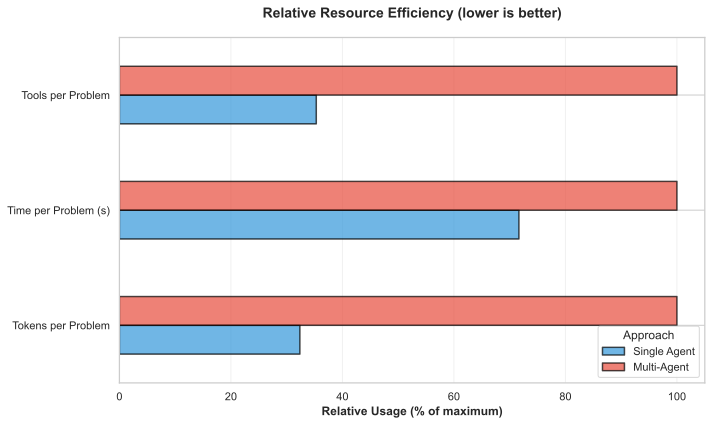

In [21]:
# Calculate efficiency metrics
efficiency_data = {
    'Approach': ['Single Agent', 'Multi-Agent'],
    'Tokens per Problem': [single_tokens / len(PROBLEMS), multi_tokens / len(PROBLEMS)],
    'Time per Problem (s)': [single_time / len(PROBLEMS), multi_time / len(PROBLEMS)],
    'Tools per Problem': [single_tools / len(PROBLEMS), multi_tools / len(PROBLEMS)],
}

efficiency_df = pd.DataFrame(efficiency_data)
efficiency_df['Tokens per Problem'] = efficiency_df['Tokens per Problem'].round(0).astype(int)
efficiency_df['Time per Problem (s)'] = efficiency_df['Time per Problem (s)'].round(2)
efficiency_df['Tools per Problem'] = efficiency_df['Tools per Problem'].round(1)

print("Efficiency Metrics (Average per Problem):")
display(efficiency_df)

# Visualize efficiency
fig, ax = plt.subplots(figsize=(10, 6))

normalized_data = efficiency_df.set_index('Approach').T
normalized_data_scaled = normalized_data.div(normalized_data.max(axis=1), axis=0) * 100

normalized_data_scaled.plot(kind='barh', ax=ax, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Relative Usage (% of maximum)', fontsize=12, fontweight='bold')
ax.set_title('Relative Resource Efficiency (lower is better)', fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Approach', loc='lower right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()